In [2]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

# CUSTOMERS

1) First of all, we import our dataset about customers. We have the unique identifier for each customer and its age. Furthermore, we know whether he or she is subscribed to the newsletter (1 if yes, 0 if no) and if he or she is part of the special club member.

We have a look to how data are structured, printing the first five items and we get a general idea of the quantity of the data, using the shape function.

In [3]:
customers = pd.read_csv("recsys_customers.csv")
customers.head()

,customer_id,fashion_news,club_member,age
0,0,1,1,44.0
1,1,1,1,33.0
2,2,0,0,29.0
3,3,0,0,21.0
4,4,0,0,23.0


In [4]:
customers.shape

(41253, 4)

2) We want to find the columns that may have NaN values in order to handle them.

In [5]:
customers.isnull().sum()

customer_id       0
fashion_news      0
club_member       0
age             133
dtype: int64

Out of 4 columns, only 1 column has null values, which is age. 

To understand better the weight of these null values on the whole set, we can calculate their weight relative to the length of the dataset.

In [6]:
null_percentage= customers['age'].isnull().sum()/ len(customers)
print('The null percentage of age is: ' + str(null_percentage))

The null percentage of age is: 0.0032240079509369014


The percentage of missing values is quite low, around 0.32%. 
At this point we can choose to follow 2 paths:
- Delete all the rows that contain a null value for age.
- We can fill the null cells with the most common values for age.

We decided to proceed by substituting all NaN values with the mode of the values of age, which is 26.

In [7]:
customers.age.mode()

0    26.0
Name: age, dtype: float64

In [8]:
customers['age'] = customers['age'].fillna(customers['age'].mode()[0])

3) As we want our data to be as readable and interpretable as possible, we want to convert the age type from float to integer.

In [9]:
customers["age"] = customers["age"].apply(lambda x: int(x))
customers.head()

,customer_id,fashion_news,club_member,age
0,0,1,1,44
1,1,1,1,33
2,2,0,0,29
3,3,0,0,21
4,4,0,0,23


4) To get a better insight of our data we want to divide customers in 5 categories depending on their age. 

To simplify things, we calculate the maximum and minimum of the age values and then we create our "clusters".

In [10]:
print('The minimum age recorded is: ' + str(min(customers["age"])))
print('The maximum age recorded is: ' + str(max(customers["age"])))

The minimum age recorded is: 16
The maximum age recorded is: 91


What are we doing? We assign each customer to the proper age category adding a column to the initial table.

In [11]:
bins = [15, 30, 45, 60, 70, 92]
groups = ['15-29', '30-44', '45-59','60-79', '80+']

customers['age_group'] = pd.cut(customers.age, bins, labels = groups, include_lowest=True)
customers

,customer_id,fashion_news,club_member,age,age_group
0,0,1,1,44,30-44
1,1,1,1,33,30-44
2,2,0,0,29,15-29
3,3,0,0,21,15-29
4,4,0,0,23,15-29
...,...,...,...,...,...
41248,41248,1,1,33,30-44
41249,41249,0,0,25,15-29
41250,41250,1,1,20,15-29
41251,41251,1,1,29,15-29


After that we have categorized each customer, we can start to count how many members belong to each category. We do this using the group by function. Obviously, the total number of the members in each category is equal to the length of the dataset.

In [12]:
age_group_counts = customers.groupby('age_group').size()
age_group_counts

age_group
15-29    20465
30-44     9971
45-59     9533
60-79     1111
80+        173
dtype: int64

In [13]:
''' same as doing
from collections import Counter 
age_group_counts2 = Counter(customers['age_group'])
age_group_counts2 '''

" same as doing\nfrom collections import Counter \nage_group_counts2 = Counter(customers['age_group'])\nage_group_counts2 "

5) We are know ready to plot our age groups into a barplot to see the hetereogeneity of our dataset. In fact, as we expected, there are much more younger customers with respect to older ones.

In [14]:
age_group_counts_df = pd.DataFrame([age_group_counts]).T.reset_index()
age_group_counts_df.columns = ['Age Group', 'Count']
age_group_counts_df

,Age Group,Count
0,15-29,20465
1,30-44,9971
2,45-59,9533
3,60-79,1111
4,80+,173


6) We can plot our results to better capture the age distribution of our data. In our dataset there are much more people under 60 years old with respect to people over 60.
The percentage of people below 60 years old is 96.8%!!!

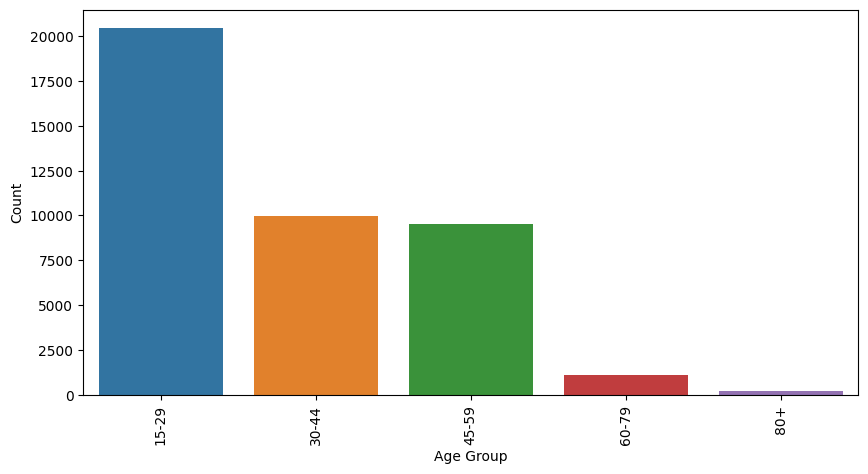

In [15]:
plt.figure(figsize=(10,5))
sns.barplot(x='Age Group', y='Count', data=age_group_counts_df)
plt.xticks(rotation=90)
plt.show()

In [16]:
people_under_60 = age_group_counts[0]+age_group_counts[1]+age_group_counts[2]
people_over_60 = age_group_counts[3]+age_group_counts[4]
total_number_customers = people_under_60 + people_over_60
print(f'The percentage of people under 60 years old is: {( people_under_60 / total_number_customers) }')

The percentage of people under 60 years old is: 0.968874990909752


7) Actually, it would be better for us also to capture how many people inside each age group have agreed to be part in the member club and how many people have activated the fashion news.

We know that both columns of 'club member' and 'fashion news' have two possible values:
- 1 if the customer is subscribed to the club member or to fashion news
- 0 if the customer is not subscribed

#### Club membership

In [17]:
from collections import Counter

club_general = Counter(customers['club_member'])
club_general

Counter({1: 17975, 0: 23278})

We create a dataframe that contains the two options (being subscribed or not being subscribed) and we count how many customers there are in each of them.

In [18]:
club_general_df = pd.DataFrame([club_general]).T.reset_index()
club_general_df.columns = ['Premium Club (1=yes, 0=no)', 'Count']
club_general_df

,"Premium Club (1=yes, 0=no)",Count
0,1,17975
1,0,23278


We plot the graph of the dataframe. However it does not tell us a lot because we do not know to which group age each customer belongs. Therefore, we might decide to create a more accurate dataframe which always categorizes customers in two classes (subscribed or not subscribed) but at the same time, clusters the clients also by age group. In this way we can capture more information.

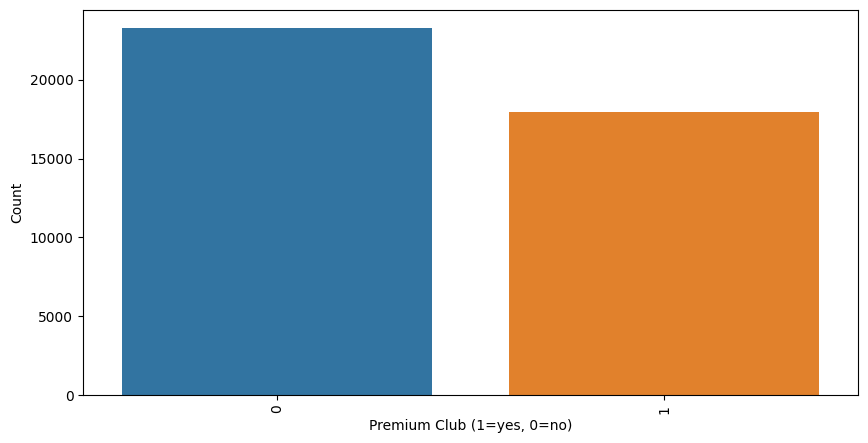

In [19]:
plt.figure(figsize=(10,5))
sns.barplot(x='Premium Club (1=yes, 0=no)', y='Count', data=club_general_df)
plt.xticks(rotation=90)
plt.show()

In [20]:
club_member_df = customers.groupby(['age_group', 'club_member']).count().reset_index()
club_member_df = club_member_df.drop(columns=['fashion_news', 'age'])
club_member_df.columns = ['age_group', 'club_member', 'count']
club_member_df

,age_group,club_member,count
0,15-29,0,12039
1,15-29,1,8426
2,30-44,0,5764
3,30-44,1,4207
4,45-59,0,4938
5,45-59,1,4595
6,60-79,0,469
7,60-79,1,642
8,80+,0,68
9,80+,1,105


For instance, on average there are more people which are not subscribed to the premium club. However, most of the people who are subscribed are youngsters. For what concerns elderly people, their percentage of influence in the dataset is very small.

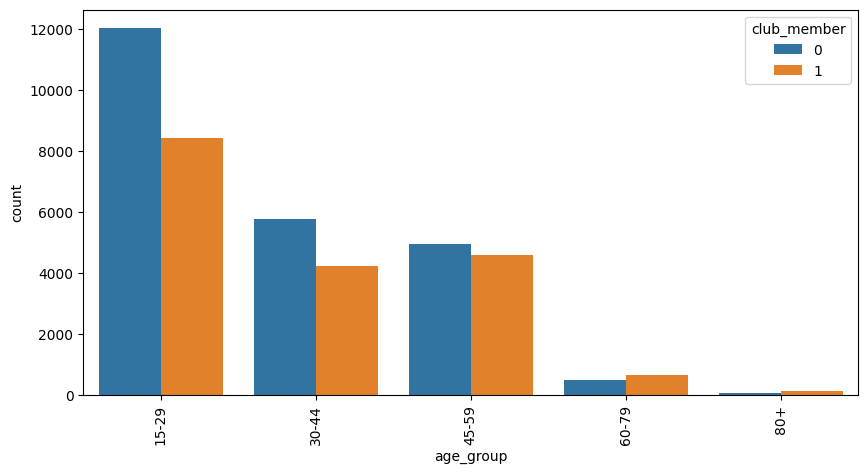

In [21]:
plt.figure(figsize=(10,5))
sns.barplot(x='age_group', y='count', hue='club_member', data=club_member_df)
plt.xticks(rotation=90)
plt.show()

#### Fashion news

In [22]:
from collections import Counter
fashion_general = Counter(customers['fashion_news'])

fashion_general_df = pd.DataFrame([fashion_general]).T.reset_index()
fashion_general_df.columns = ['Fashion News (1=yes, 0=no)', 'Count']
fashion_general_df

,"Fashion News (1=yes, 0=no)",Count
0,1,18213
1,0,23040


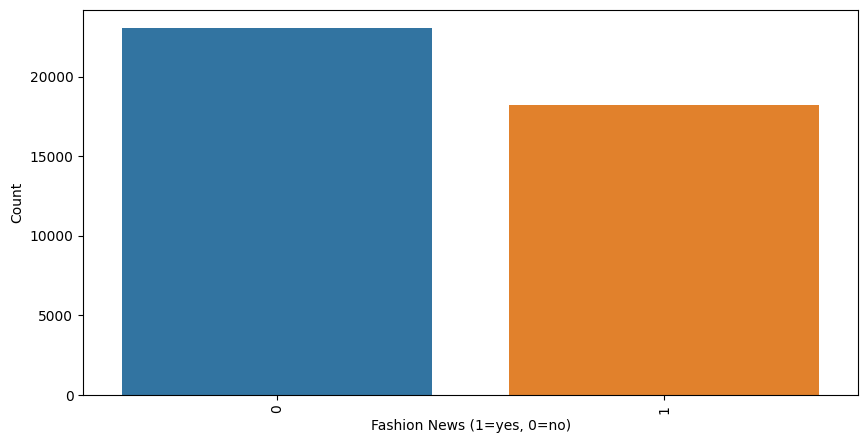

In [23]:
plt.figure(figsize=(10,5))
sns.barplot(x='Fashion News (1=yes, 0=no)', y='Count', data=fashion_general_df)
plt.xticks(rotation=90)
plt.show()

In [24]:
fashion_news_df = customers.groupby(['age_group', 'fashion_news']).count().reset_index()
fashion_news_df = fashion_news_df.drop(columns=['club_member', 'age'])
fashion_news_df.columns = ['age_group', 'fashion_news', 'count']
fashion_news_df

,age_group,fashion_news,count
0,15-29,0,11901
1,15-29,1,8564
2,30-44,0,5710
3,30-44,1,4261
4,45-59,0,4899
5,45-59,1,4634
6,60-79,0,462
7,60-79,1,649
8,80+,0,68
9,80+,1,105


From the graph underneath, we can see again that yougsters are a vast majority of members connected to fashion news. However, the probability that a person over 60 is connected to fashion news is higher to not being connected with respect to younger people.

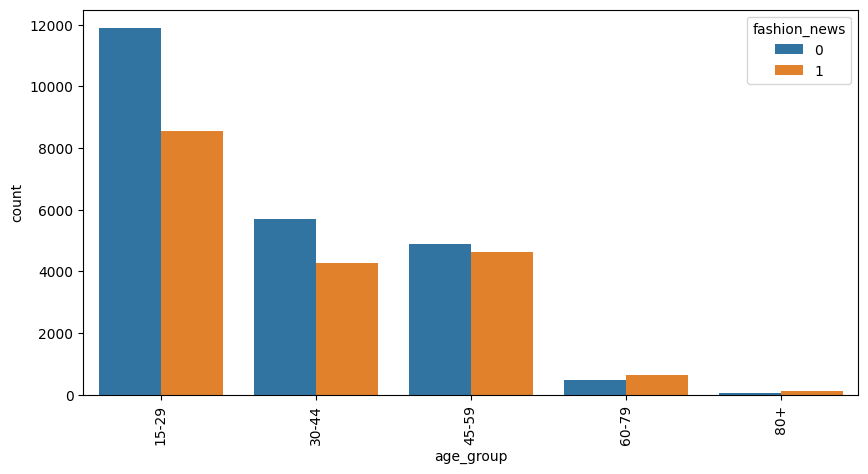

In [25]:
plt.figure(figsize=(10,5))
sns.barplot(x='age_group', y='count', hue='fashion_news', data=fashion_news_df)
plt.xticks(rotation=90)
plt.show()

As a conclusion, what useful information can we use for our recommendation system?
- Data of customers in the cutomers' dataset is not very homogeneous (almost 97% of the population is below 60 years old).
- People over 60 years old have an higher probability to be subscribed to fashion news and member club with respect to people under 60 years old.
- In general there are more people who are not into these activities.

# ARTICLES

In the second part of our data analysis, we will study the different articles that our company sells. The final aim is to be able to understand when different articles are similiar or different and therefore, when to suggest one of them basing on the previous orders. 
Let's take a look to this dataset:

In [26]:
articles = pd.read_csv("recsys_articles.csv")
articles

,article_id,prod_name,product_type,product_type_name,product_group_name,colour_group,colour_group_name,perceived_colour_value,perceived_colour_value_name,perceived_colour_master,...,department,department_name,index,index_name,index_group,index_group_name,section,section_name,garment_group,garment_group_name
0,0,20 den 1p Stockings,304,Underwear Tights,Socks & Tights,9,Black,4,Dark,5,...,3608,Tights basic,B,Lingeries/Tights,1,Ladieswear,62,"Womens Nightwear, Socks & Tigh",1021,Socks and Tights
1,1,Shape Up 30 den 1p Tights,273,Leggings/Tights,Garment Lower body,9,Black,4,Dark,5,...,3608,Tights basic,B,Lingeries/Tights,1,Ladieswear,62,"Womens Nightwear, Socks & Tigh",1021,Socks and Tights
2,2,Support 40 den 1p Tights,304,Underwear Tights,Socks & Tights,9,Black,4,Dark,5,...,3608,Tights basic,B,Lingeries/Tights,1,Ladieswear,62,"Womens Nightwear, Socks & Tigh",1021,Socks and Tights
3,3,200 den 1p Tights,304,Underwear Tights,Socks & Tights,9,Black,4,Dark,5,...,3608,Tights basic,B,Lingeries/Tights,1,Ladieswear,62,"Womens Nightwear, Socks & Tigh",1021,Socks and Tights
4,4,Control Top 50 den 1p Tights,273,Leggings/Tights,Garment Lower body,9,Black,4,Dark,5,...,3608,Tights basic,B,Lingeries/Tights,1,Ladieswear,62,"Womens Nightwear, Socks & Tigh",1021,Socks and Tights
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6531,6531,Virgo sweater fast buy,252,Sweater,Garment Upper body,9,Black,4,Dark,5,...,1640,Tops Fancy Jersey,D,Divided,2,Divided,53,Divided Collection,1005,Jersey Fancy
6532,6532,Virgo sweater fast buy,252,Sweater,Garment Upper body,52,Pink,1,Dusty Light,4,...,1640,Tops Fancy Jersey,D,Divided,2,Divided,53,Divided Collection,1005,Jersey Fancy
6533,6533,Heavy plain overknee tights 1p,304,Underwear Tights,Socks & Tights,9,Black,4,Dark,5,...,3608,Tights basic,B,Lingeries/Tights,1,Ladieswear,62,"Womens Nightwear, Socks & Tigh",1021,Socks and Tights
6534,6534,SPORT Malaga tank,253,Vest top,Garment Upper body,9,Black,4,Dark,5,...,1919,Jersey,A,Ladieswear,1,Ladieswear,2,H&M+,1005,Jersey Fancy


As we can easily see, this dataset has a more complex structure than the one analyzed before, but we can for sure ignore some columns.
Each category is represented by two columns and for this reason, we can take only one and discard the other.
For example, each product has the variable 'product_type' containing its ID code and the variable 'product_type_name' that is the full name of the product.
Therefore, we can choose some variables to consider and someother to ignore.

1) As we did for customers, we want to check how many values are null. Luckily, this time we have zero null values.

In [27]:
articles.isnull().sum()

article_id                      0
prod_name                       0
product_type                    0
product_type_name               0
product_group_name              0
colour_group                    0
colour_group_name               0
perceived_colour_value          0
perceived_colour_value_name     0
perceived_colour_master         0
perceived_colour_master_name    0
department                      0
department_name                 0
index                           0
index_name                      0
index_group                     0
index_group_name                0
section                         0
section_name                    0
garment_group                   0
garment_group_name              0
dtype: int64

2) Now we can group our articles in different ways, starting from the division in categories.

#### Categories

We want to see how our products are partitioned according to their category. We analyze how these categories are structured and we find the number of articles for each of them.

From the dataframe, we see that the product type with more articles is 'Trousers', with exactly 972 different models.

In [28]:
type_article_count = Counter(articles['product_type_name'])
type_article_count_df = pd.DataFrame([type_article_count]).T.reset_index()
type_article_count_df.columns = ['Type', 'Count']
type_article_count_df.sort_values(by='Count', ascending=False) #We sort the dataframe in order to see the biggest types without any code

,Type,Count
18,Trousers,972
3,Sweater,635
11,Dress,578
21,Top,422
17,T-shirt,382
...,...,...
30,Braces,1
78,Hairband,1
79,Flat shoes,1
31,Nipple covers,1


Let's see a visual representation:

The plot underneath is useful, but also too caothic (82 categories are too many). A great solution is to regroup our categories (types) in some larger categories (groups).

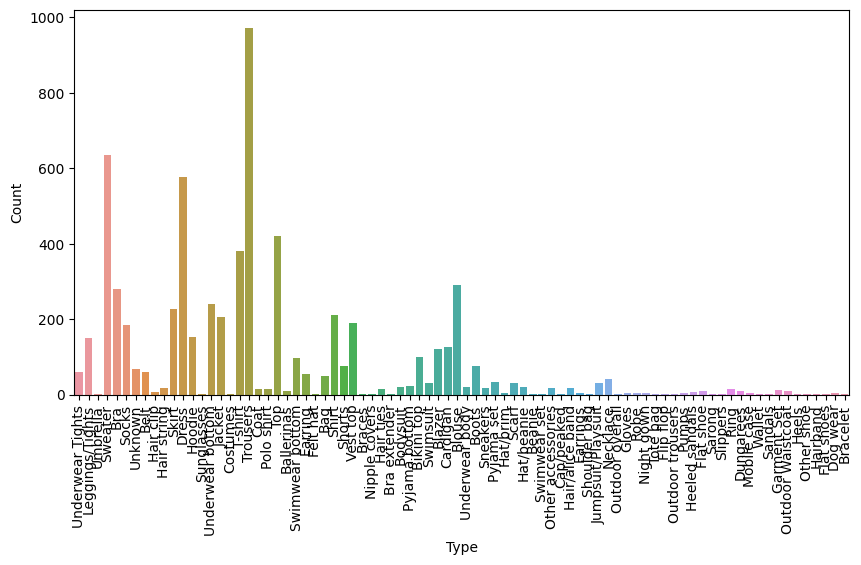

In [91]:
plt.figure(figsize=(10,5))
sns.barplot(x='Type', y='Count', data=type_article_count_df)
plt.xticks(rotation=90)
plt.show()

In [30]:
group_article_count = Counter(articles['product_group_name'])
group_article_count_df = pd.DataFrame([group_article_count]).T.reset_index()
group_article_count_df.columns = ['Group', 'Count']
group_article_count_df.sort_values(by='Count', ascending=False)

,Group,Count
3,Garment Upper body,2799
1,Garment Lower body,1428
7,Garment Full body,632
4,Underwear,547
6,Accessories,378
0,Socks & Tights,245
9,Swimwear,233
8,Shoes,135
5,Unknown,67
10,Nightwear,60


This time, we directly see all the classification for groups, where the winner is Garment Upper body, with 2799 different articles.

One more time, the plot:

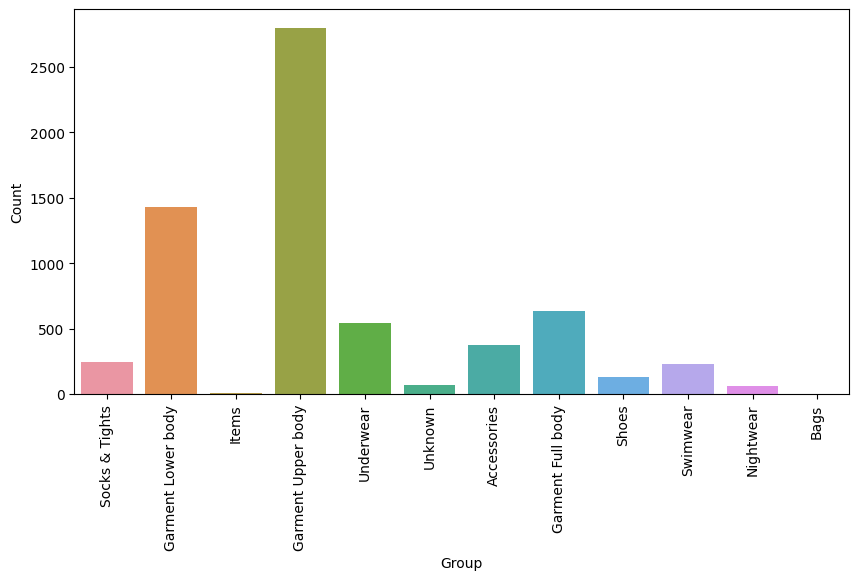

In [31]:
plt.figure(figsize=(10,5))
sns.barplot(x='Group', y='Count', data=group_article_count_df)
plt.xticks(rotation=90)
plt.show()

Now we have a more simpler plot, where we can identify the top categories just by seeing them.

As we can easily see from this last plot, we have some articles that not belong to any group, so we want to identify them:

In [29]:
articles.loc[articles['product_group_name'] == 'Unknown']

,article_id,prod_name,product_type,product_type_name,product_group_name,colour_group,colour_group_name,perceived_colour_value,perceived_colour_value_name,perceived_colour_master,...,department,department_name,index,index_name,index_group,index_group_name,section,section_name,garment_group,garment_group_name
14,14,Box 4p Socks,-1,Unknown,Unknown,9,Black,4,Dark,5,...,3608,Tights basic,B,Lingeries/Tights,1,Ladieswear,62,"Womens Nightwear, Socks & Tigh",1021,Socks and Tights
203,203,OP Cheeky hipster 2p,-1,Unknown,Unknown,9,Black,4,Dark,5,...,1339,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear"
204,204,OP Cheeky hipster 2p,-1,Unknown,Unknown,12,Light Beige,1,Dusty Light,11,...,1339,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear"
205,205,OP Cheeky hipster 2p,-1,Unknown,Unknown,17,Yellowish Brown,2,Medium Dusty,13,...,1339,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear"
206,206,OP Cheeky hipster 2p,-1,Unknown,Unknown,17,Yellowish Brown,4,Dark,13,...,1339,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5117,5117,Chandler HW Cord TRS,-1,Unknown,Unknown,7,Grey,2,Medium Dusty,12,...,1747,Trousers,D,Divided,2,Divided,53,Divided Collection,1009,Trousers
5118,5118,Chandler HW Cord TRS,-1,Unknown,Unknown,14,Dark Beige,4,Dark,11,...,1747,Trousers,D,Divided,2,Divided,53,Divided Collection,1009,Trousers
5160,5160,Energy 2-pack,-1,Unknown,Unknown,9,Black,4,Dark,5,...,8316,Ladies Sport Bras,S,Sport,26,Sport,5,Ladies H&M Sport,1005,Jersey Fancy
6047,6047,Brady Pull On Cord,-1,Unknown,Unknown,14,Dark Beige,2,Medium Dusty,13,...,5656,Trouser,F,Menswear,3,Menswear,21,Contemporary Casual,1009,Trousers


# TRANSACTIONS

In [85]:
transactions = pd.read_csv("recsys_transactions.csv")
transactions.head()

,t_dat,customer_id,article_id
0,2020-09-02,7,599
1,2020-09-02,7,2600
2,2020-09-02,7,2063
3,2020-09-02,7,5188
4,2020-09-02,17,5111


The last dataset we are going to study is "recsys_transactions.csv". Its information are the date of purchase, the customer id and the product id. The same customer can purchase more articles.

To be in do doubt, we check there are Null values that might interfere with our analysis.

In [33]:
transactions.isnull().sum()

t_dat          0
customer_id    0
article_id     0
dtype: int64

# INGLESE PESSIMO, DA RIVEDERE  

This result was not hard to predict.
Indeed, looking to this dataset, we observe that it is based on a relationship between the other 2 datasets so, all the rows are composed by the IDs of an article and and a costumer.
Without one of these 2 values, the row will give us zero relevant informations and so would be unuseful to process it.



We would like to see how many purchases has done each customer. We create a dataframe with 2 columns: on one side the customer ID and on the other the number of purchases each customer has made.

In [34]:
from collections import Counter
customer_transactions_count = Counter(transactions['customer_id'])
#transactions.groupby('customer_id').size()
#outputs a long dictionary with key the id of the customer and value the number of purchases he or she has made

In [46]:
customer_transactions_count_df = pd.DataFrame([customer_transactions_count]).T.reset_index()
customer_transactions_count_df.columns = ['Customer ID', 'Number of Transactions']
#customer_transactions_count_df= customer_transactions_count_df.sort_values(by='Customer ID', ascending=True).reset_index()
customer_transactions_count_df.sort_values(by='Number of Transactions', ascending=False)

,Customer ID,Number of Transactions
38291,9197,104
35275,36953,95
4445,16472,92
27086,13753,88
5953,33914,85
...,...,...
31161,24874,1
4048,11884,1
12285,36144,1
12292,36223,1


The customer who has ultimated the highest amount of purchases is the user '9197' with exactly 104 transactions.

Sorting by descending, we are able to see not only the first user by transactions, but also a ranking(classifica) based on transactions for users.

It is also interesting to see everything on the other way around, so how many times each item has been bought by customers.

In [62]:
article_transactions_count = Counter(transactions['article_id'])

In [45]:
article_transactions_count_df = pd.DataFrame([article_transactions_count]).T.reset_index()
article_transactions_count_df.columns = ['Article ID', 'Number of Transactions']
article_transactions_count_df.sort_values(by='Number of Transactions', ascending=False)

,Article ID,Number of Transactions
48,1419,1045
927,168,896
63,5831,889
1359,6166,858
318,1429,815
...,...,...
2651,1692,11
4160,5324,11
2689,2536,11
2692,2625,11


Again, just to be sure, we check that there is no product that has never been bought.

In [49]:
article_transactions_count_df[article_transactions_count_df['Number of Transactions'] == '0']

,Article ID,Number of Transactions


Same as before, we sorted the values to see the most wanted articles.
This time, we can access to more information than the case studied before.
In fact, while for the customers we can access to a restricted range of information (lot of them are sensitive data) for products we can see more information useful to market strategies.
So, let'see what is this 'id 1419':

In [66]:
articles.loc[articles['article_id'] == 1419]

,article_id,prod_name,product_type,product_type_name,product_group_name,colour_group,colour_group_name,perceived_colour_value,perceived_colour_value_name,perceived_colour_master,...,department,department_name,index,index_name,index_group,index_group_name,section,section_name,garment_group,garment_group_name
981,981,OP T-shirt Milano,-1,Unknown,Unknown,12,Light Beige,1,Dusty Light,11,...,1338,Expressive Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear"


This row gives us a lot of information, maybe too many.
In fact, in our opinion, is better to focus on category in spite of single products, because we can have a more accurate analysis basing on a bigger radius of articles, avoiding in this way some outliers.

In [77]:
article_type_dict = {}
article_group_dict = {}

for i,row in articles.iterrows():
    article_type_dict[row['article_id']] = row['product_type_name']
    article_group_dict[row['article_id']] = row['product_group_name']

In [80]:
type_transactions = {}
for i,row in transactions.iterrows():
    if article_type_dict[row['article_id']] in type_transactions.keys():
        type_transactions[article_type_dict[row['article_id']]] += 1
    else:
        type_transactions[article_type_dict[row['article_id']]] = 1
        
type_transactions_df = pd.DataFrame({'Type of products':list(type_transactions.keys()),'Number of Transactions':list(type_transactions.values())})
type_transactions_df.sort_values(by='Number of Transactions', ascending = False)

,Type of product,Number of Transactions
5,Trousers,65295
11,Sweater,49602
2,Top,28308
3,Dress,26333
23,T-shirt,21010
...,...,...
69,Swimwear set,16
71,Braces,15
75,Flip flop,14
78,Heels,13


And thanks to this frame we can see that the most sold type of product is the Trousers, with a huge distance from the second one. This is probably caused by the fact that trousers is also the type of product with more different articles inside.

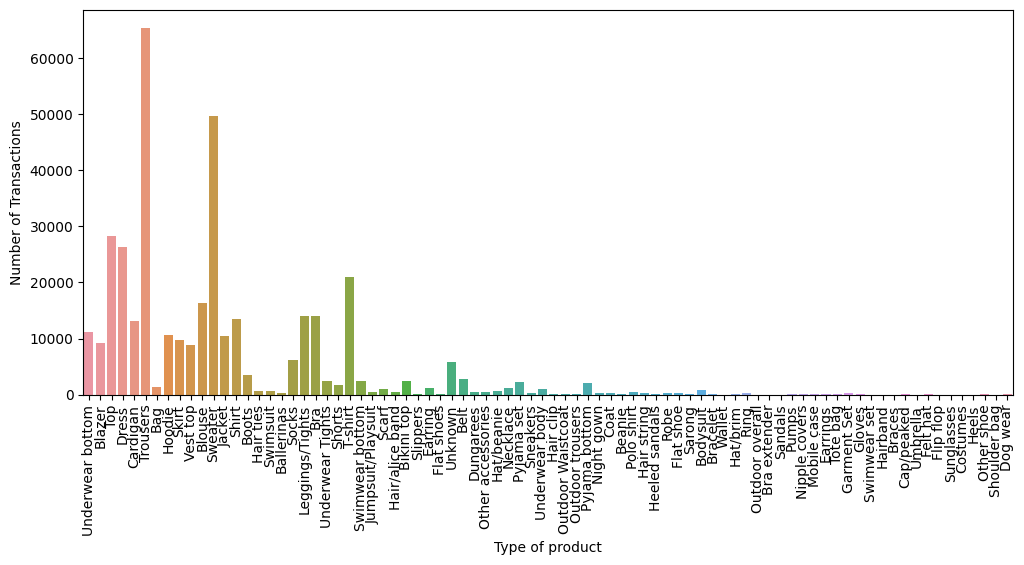

In [81]:
plt.figure(figsize=(12,5))
sns.barplot(x='Type of product', y='Number of Transactions', data=type_transactions_df)
plt.xticks(rotation=90)
plt.show()

Now let's do the same analysis byt this time focusing on the group of articles.

In [86]:
group_transactions = {}
for i,row in transactions.iterrows():
    if article_group_dict[row['article_id']] in group_transactions.keys():
        group_transactions[article_group_dict[row['article_id']]] += 1
    else:
        group_transactions[article_group_dict[row['article_id']]] = 1
        
group_transactions_df = pd.DataFrame({'Group of products':list(group_transactions.keys()),'Number of Transactions':list(group_transactions.values())})
group_transactions_df.sort_values(by='Number of Transactions', ascending = False)

,Group of products,Number of Transactions
1,Garment Upper body,182576
3,Garment Lower body,91015
2,Garment Full body,27687
0,Underwear,26365
4,Accessories,11335
7,Socks & Tights,8701
8,Unknown,5847
6,Swimwear,5686
5,Shoes,4977
9,Nightwear,4623


And one more time, we got the expexted result, since 'Garment Upper body' is the most populate group.
In this case, the distance between the top group and the others is incredibly huge (It is the double of the second ranked group).

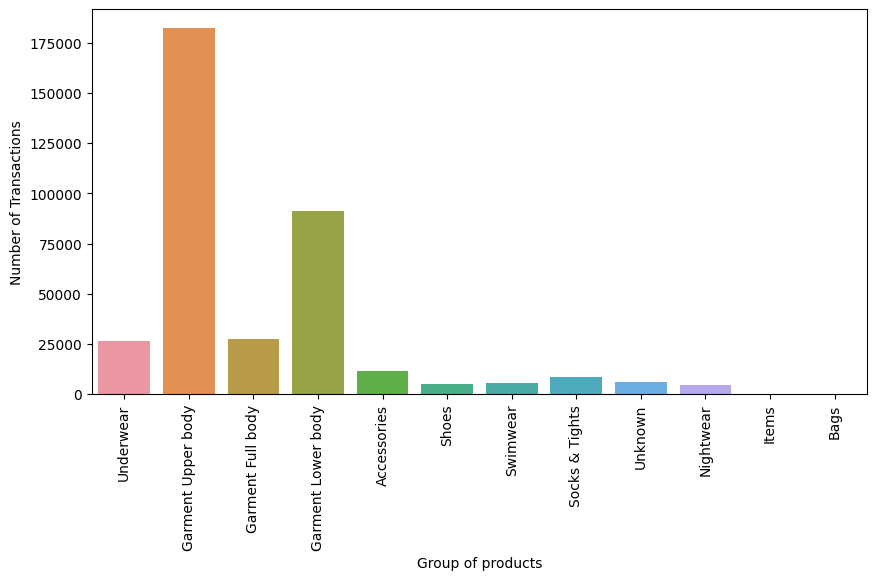

In [90]:
plt.figure(figsize=(10,5))
sns.barplot(x='Group of products', y='Number of Transactions', data=group_transactions_df)
plt.xticks(rotation=90)
plt.show()

We can also see which is the day with the most number of transactions:

In [93]:
day_count = Counter(transactions['t_dat'])
day_count_df = pd.DataFrame([day_count]).T.reset_index()
day_count_df.columns = ['Day', 'Count']
day_count_df.sort_values(by='Count', ascending=False)

,Day,Count
11,2020-09-13,21209
7,2020-09-09,21155
15,2020-09-17,20458
8,2020-09-10,19531
5,2020-09-07,19473
16,2020-09-18,19129
3,2020-09-05,18990
10,2020-09-12,18926
1,2020-09-03,18557
6,2020-09-08,18535


Now we know that the day with the biggest number of transactions is the 13th of september, which was a sunday.